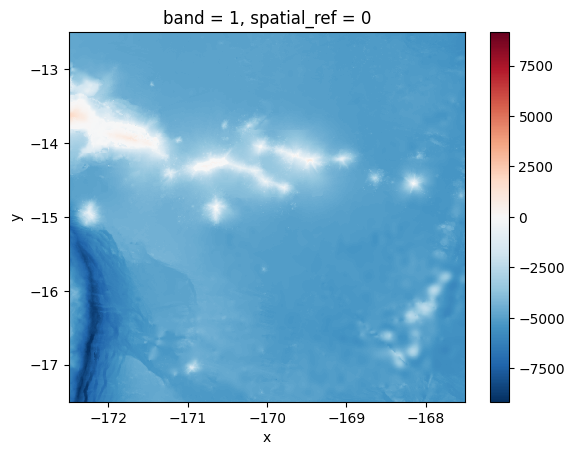

In [1]:
import rioxarray as rxr
import numpy as np
import xarray as xr
import pandas as pd
# Load the DEM
dem1 = rxr.open_rasterio("data/DEM/ETOPO_2022_Bedrock_15.tiff", masked=True).squeeze()

# Check spatial coordinates and plot
dem1.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
dem1.plot()

In [2]:
target_lons = np.array([187.5, 190.0, 192.5])
target_lats = np.array([-12.5, -15.0, -17.5])

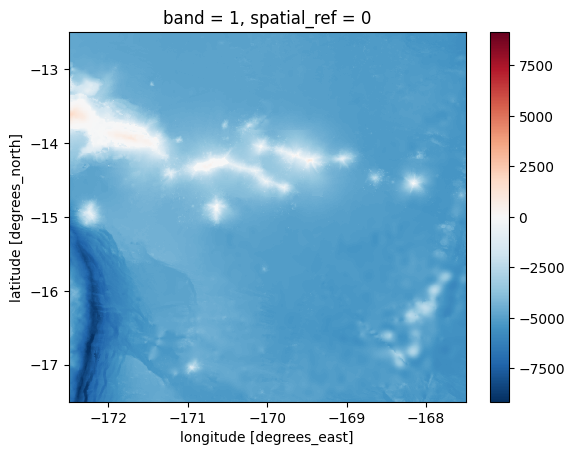

In [3]:
# Load both DEMs
etopo = rxr.open_rasterio("data/DEM/ETOPO_2022_Bedrock_15.tiff", masked=True).squeeze()
gt30 = rxr.open_rasterio("data/DEM/gt30w180s10.tif", masked=True).squeeze()

# Ensure CRS is set (if missing)
if etopo.rio.crs is None:
    etopo.rio.write_crs("EPSG:4326", inplace=True)

if gt30.rio.crs is None:
    gt30.rio.write_crs("EPSG:4326", inplace=True)
gt30_resampled = gt30.rio.reproject_match(etopo)
dem = gt30_resampled.where(~gt30_resampled.isnull(), etopo)

# Check spatial coordinates and plot
dem.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
dem.plot()

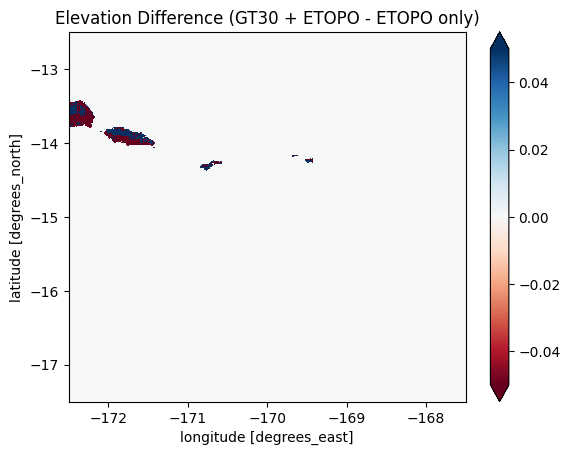

In [4]:
import matplotlib.pyplot as plt

diff = dem - dem1
diff.plot(cmap="RdBu", robust=True)
plt.title("Elevation Difference (GT30 + ETOPO - ETOPO only)")
plt.show()


In [5]:
def convert_lon(lon):
    return lon - 360 if lon > 180 else lon

climate_lat = list(target_lats)  # already north to south
climate_lon = [convert_lon(lon) for lon in target_lons]  # west to east: [-172.5, -170.0, -167.5]
print(climate_lat, climate_lon)

[np.float64(-12.5), np.float64(-15.0), np.float64(-17.5)] [np.float64(-172.5), np.float64(-170.0), np.float64(-167.5)]


In [6]:
def extract_dem_patch(dem, lat, lon, box_km, out_shape=(5, 5)):
    """
    Extract a DEM patch centered at (lat, lon), covering a box_km x box_km region,
    resampled to out_shape resolution.
    """
    import geopandas as gpd
    from rasterio.warp import transform_bounds
    from shapely.geometry import box

    # Convert km to degrees (rough approx — valid near equator)
    box_deg = box_km / 111.0  # 1° ~ 111 km

    lat_min = lat - box_deg / 2
    lat_max = lat + box_deg / 2
    lon_min = lon - box_deg / 2
    lon_max = lon + box_deg / 2

    # Clip DEM to bounding box
    clipped = dem.sel(
        x=slice(lon_min, lon_max),
        y=slice(lat_max, lat_min)  # note: y=lat is often descending
    )

    print(f"Clipped shape: {clipped.shape}, min: {np.nanmin(clipped.values)}, max: {np.nanmax(clipped.values)}")

    if clipped.x.size == 0 or clipped.y.size == 0:
        raise ValueError(f"No DEM data in the box for lat={lat}, lon={lon}")

    # Resample to 5x5
    patch = clipped.interp(
    x=np.linspace(lon_min, lon_max, out_shape[1]),
    y=np.linspace(lat_max, lat_min, out_shape[0]),
    method="nearest"
)

    # Replace NaNs with 0 (sea level)
    return np.nan_to_num(patch.values, nan=0.0)


In [7]:
import numpy as np

local_patches = []
regional_patches = []

for lat in climate_lat:
    for lon in climate_lon:
        local = extract_dem_patch(dem, lat, lon, box_km=40)  # 20 km area → ~4 km per pixel
        regional = extract_dem_patch(dem, lat, lon, box_km=120)  # 60 km area → ~12 km per pixel
        local_patches.append(local)
        regional_patches.append(regional)


Clipped shape: (43, 43), min: -4854.0, max: -4740.0
Clipped shape: (130, 130), min: -4899.0, max: -2869.0
Clipped shape: (43, 86), min: -5029.14697265625, max: -4647.9970703125
Clipped shape: (130, 260), min: -5361.0, max: -4600.00048828125
Clipped shape: (43, 43), min: -5684.0, max: -5343.0
Clipped shape: (130, 130), min: -5684.0, max: -5026.0
Clipped shape: (86, 43), min: -7462.748046875, max: -2449.029541015625
Clipped shape: (260, 130), min: -8301.1220703125, max: -659.5762329101562
Clipped shape: (86, 86), min: -5060.0, max: -4077.0
Clipped shape: (260, 260), min: -5459.0, max: -174.66796875
Clipped shape: (86, 43), min: -5679.0, max: -4507.0
Clipped shape: (260, 130), min: -5686.0, max: -3613.8798828125
Clipped shape: (43, 43), min: -9115.16796875, max: -5789.56103515625
Clipped shape: (130, 130), min: -9136.0078125, max: -4636.1708984375
Clipped shape: (43, 86), min: -5160.0673828125, max: -4094.0
Clipped shape: (130, 260), min: -5487.0, max: -4094.0
Clipped shape: (43, 43), min

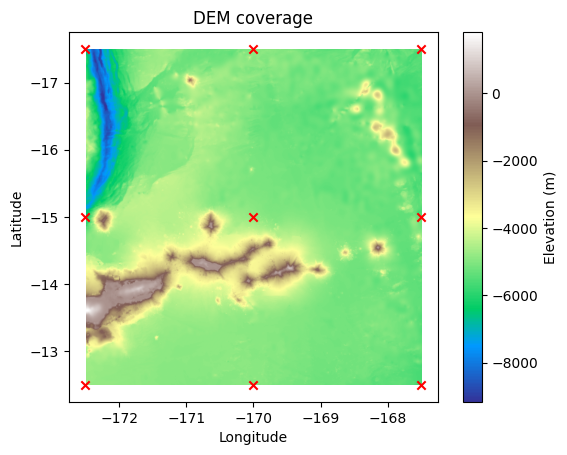

In [8]:
import matplotlib.pyplot as plt

plt.imshow(dem.values, cmap="terrain", extent=[
    dem.x.min(), dem.x.max(),
    dem.y.min(), dem.y.max()
])

lon_grid, lat_grid = np.meshgrid(climate_lon, climate_lat)

plt.colorbar(label="Elevation (m)")
plt.title("DEM coverage")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.scatter(lon_grid.ravel(), lat_grid.ravel(), c="red", marker="x")
plt.gca().invert_yaxis()  # optional: make north at top
plt.show()


In [9]:
climate_data = xr.open_dataset("AS_climate_var.nc")
climate_data

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jlee/Desktop/github/RainfallPredictionWithClimateData/AS_climate_var.nc'

In [ ]:
import numpy as np

# Assume these shapes:
# climate_data: (time, lat, lon, 16)
# rainfall_data: (time, lat, lon)
# local_dems, regional_dems: (lat, lon, 5, 5)
# months: (time,) — integers 1–12

climate_data = xr.open_dataset("AS_climate_var.nc")
time_len = 804
lat_len = 3
lon_len = 3
num_climate_vars = 16
num_points = time_len * lat_len * lon_len

X = []
y = []

for t in range(time_len):
    # One-hot encode the month
    month_one_hot = np.zeros(12)
    month_idx = months[t] - 1
    month_one_hot[month_idx] = 1

    for i in range(lat_len):
        for j in range(lon_len):
            # Climate variables (length 16)
            climate_vec = climate_data[t, i, j, :]  # shape (16,)

            # Local + regional DEM (flattened 5x5)
            local_patch = local_dems[i, j].flatten()  # shape (25,)
            regional_patch = regional_dems[i, j].flatten()  # shape (25,)

            # Combine features
            features = np.concatenate([
                climate_vec,
                local_patch,
                regional_patch,
                month_one_hot
            ])  # shape (16 + 25 + 25 + 12 = 78)

            X.append(features)

            # Label = observed rainfall
            y.append(rainfall_data[t, i, j])

X = np.array(X)  # shape (7200, 78) if time=800 and grid=3x3
y = np.array(y)  # shape (7200,)


NameError: name 'months' is not defined

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestRegressor()
model.fit(X_train, y_train)

print("Test RMSE:", np.sqrt(((model.predict(X_test) - y_test) ** 2).mean()))


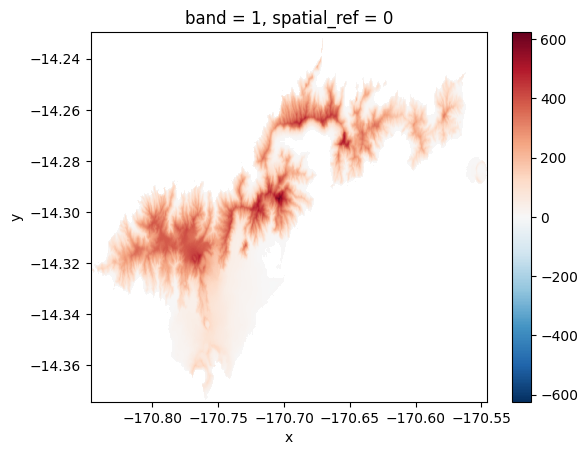

In [12]:
# Load the DEM
dem2 = rxr.open_rasterio("data/DEM/DEM-Tut1.tif", masked=True).squeeze()

# Check spatial coordinates and plot
dem2.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
dem2.plot()